In [19]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
plt.style.use('/projects/DEIKE/jiarongw/jiarongw-postprocessing/media/matplotlib/stylelib/jfm.mplstyle')
import pandas as pd
from matplotlib.legend_handler import HandlerTuple

In [ ]:
case_ensem = (case14,case15,case16)
l_ensem = []
for i,case in enumerate(case_ensem):
    l = draw(case)
    l_ensem.append(l)

In [7]:
case_ensem = (case_rerun1,case_rerun2,case_rerun3, case7,case9,case11, case1,case2,case3, case14,case15,case16)
for case in case_ensem:
    print(case.path)

/projects/DEIKE/jiarongw/turbulence/rerun/curved_fixREtau_boundary_REtau720_BO200_g1_ak0.1_MU16_LEVEL10_emax0.3/
/projects/DEIKE/jiarongw/turbulence/rerun/curved_fixREtau_boundary_REtau720_BO200_g4_ak0.1_MU8_LEVEL10_emax0.3/
/projects/DEIKE/jiarongw/turbulence/rerun/curved_fixREtau_boundary_REtau720_BO200_g16_ak0.1_MU4_LEVEL10_emax0.3/
/projects/DEIKE/jiarongw/turbulence/curved_fixREtau_boundary_REtau720_BO200_g1_ak0.15_MU16_LEVEL10_emax0.3/
/projects/DEIKE/jiarongw/turbulence/curved_fixREtau_boundary_REtau720_BO200_g4_ak0.15_MU8_LEVEL10_emax0.3/
/projects/DEIKE/jiarongw/turbulence/curved_fixREtau_boundary_REtau720_BO200_g16_ak0.15_MU4_LEVEL10_emax0.3/
/projects/DEIKE/jiarongw/turbulence/curved_fixREtau_boundary_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3/
/projects/DEIKE/jiarongw/turbulence/curved_fixREtau_boundary_REtau720_BO200_g4_ak0.2_MU8_LEVEL10_emax0.3/
/projects/DEIKE/jiarongw/turbulence/curved_fixREtau_boundary_REtau720_BO200_g16_ak0.2_MU4_LEVEL10_emax0.3/
/projects/DEIKE/jia

In [8]:
dir(case_rerun1)

['Bo',
 'L0',
 'LEVEL',
 'N',
 'Retau',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'ak',
 'alterMU',
 'emax',
 'eta_series',
 'f_2D',
 'field',
 'field_t',
 'g',
 'h',
 'k',
 'mean_profile',
 'mu1',
 'mu2',
 'p',
 'p_2D',
 'path',
 'phase',
 'rho1',
 'rho2',
 'sigma',
 'tsimu',
 'tstart',
 'ustar',
 'ux_2D',
 'uy_2D',
 'wave']

In [ ]:
""" Compute the phase average and the horizontal average. 
    case.uy_2D_phaseaver-case.uy_2D_horizaver is the wave coherent part.
    case.field_2D is of dimension time*Nx*Nz
    case.field_2D_phaseaver and case.field_2D_horizaver is of dimension Nx*Ny
    
    Compute the turbulent stress. 
    Use the value of ux_2D_phaseaver and uy_2D_phaseaver computed above (broadcasted back to 3D).
    Fully 3D no pre average in the spanwise: SHOULD RECHECK IF MAKES A DIFFERENCE!
"""
def compute_stress(case):
    case.ux_2D = np.array(case.ux_2D)
    case.uy_2D = np.array(case.uy_2D)
    case.f_2D = np.array(case.f_2D)

    """ Phase average (ensemble mean) """
    case.ux_2D_phaseaver = np.average(case.ux_2D, axis=0) 
    case.uy_2D_phaseaver = np.average(case.uy_2D, axis=0)
    case.f_2D_phaseaver = np.average(case.f_2D, axis=0)

    """ Horizontal average: Average over x and then broadcase to a 2D array again.
        TODO: Can add wave cordinate following average here.
    """
    case.ux_2D_horizaver = np.tile(np.average(case.ux_2D, axis=(0,1)), (512,1))
    case.uy_2D_horizaver = np.tile(np.average(case.uy_2D, axis=(0,1)), (512,1))
    case.f_2D_horizaver = np.tile(np.average(case.f_2D, axis=(0,1)), (512,1))

    """ Compute the turbulent stress.
    """
    case.uxuy_2D = []
    ux_3D_phaseaver = np.tile(case.ux_2D_phaseaver, (255,1,1))
    uy_3D_phaseaver = np.tile(case.uy_2D_phaseaver, (255,1,1))

    for (i,t) in tqdm(enumerate(case.field_t)):

        ux_3D = {'name':'ux', 'value':[]} # axis0 in z, axis1 in x, axis2 in y  (in the code)
        uy_3D = {'name':'uy', 'value':[]}
        f_3D = {'name':'f', 'value':[]}
        tsimu = t + case.tstart
        phasei = np.where(np.isclose(np.array(case.phase['t']), t))[0][0]
        idx = case.phase['idx'][phasei]

        # Read in the fields either from pickle or from slice data
        for field in (ux_3D,uy_3D,f_3D):         
            """NOTICE: to accomodate different pickle versions"""
            picklename = case.path + 'field/' + 'pickle_tiger/' + field['name']+'_t%g' % tsimu +'.pkl'
    #             picklename = working_dir + 'field/' + 'pickle_desktop/' + field['name']+'_t%g' % t +'.pkl'
            exists = os.path.exists(picklename)
            # If the pickle is there read in the pickles
            if exists:
                field['value'] = load_object(picklename)
                print('pickle restored!')
            # If no pickle read in from the slice files and pickle dump
            if not exists:
                for sn in range (0, NSLICE-1):
                    filename = case.path + 'field/'+field['name']+'_t%g_slice%g' % (tsimu,sn)
                    snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
                    snapshot.reshape([NGRID,NGRID+1])
                    field['value'].append(snapshot[:,0:NGRID].astype(np.float))
                field['value'] = np.array(field['value'])
                save_object(field['value'], picklename)           
            field['value'] = np.roll(field['value'], -idx, axis=1)

        re_stress_3D = (ux_3D['value']-ux_3D_phaseaver)*(uy_3D['value']-uy_3D_phaseaver)*(1-f_3D['value'])
        re_stress_3D = np.roll(re_stress_3D, -idx, axis=1)   
        case.uxuy_2D.append(np.average(re_stress_3D, axis=0))    

In [23]:
import os

In [100]:
# case.ux_2D time-x-y
# test = case.ux_2D[0]
# plt.imshow(case.ux_2D[0])

# case.uxuy_2D = []
# ux_3D_phaseaver = np.tile(case.ux_2D_phaseaver, (255,1,1))
# uy_3D_phaseaver = np.tile(case.uy_2D_phaseaver, (255,1,1))

# for (i,t) in tqdm(enumerate(case.field_t)):
case = case1
t = case.field_t[10]

ux_3D = {'name':'ux', 'value':[]} # axis0 in z, axis1 in x, axis2 in y  (in the code)
uy_3D = {'name':'uy', 'value':[]}
f_3D = {'name':'f', 'value':[]}
tsimu = t + case.tstart
phasei = np.where(np.isclose(np.array(case.phase['t']), t))[0][0]
idx = case.phase['idx'][phasei]

# Read in the fields either from pickle or from slice data
for field in (ux_3D,uy_3D,f_3D):         
    """NOTICE: to accomodate different pickle versions"""
    picklename = case.path + 'field/' + 'pickle_tiger/' + field['name']+'_t%g' % tsimu +'.pkl'
#             picklename = working_dir + 'field/' + 'pickle_desktop/' + field['name']+'_t%g' % t +'.pkl'
    exists = os.path.exists(picklename)
    # If the pickle is there read in the pickles
    if exists:
        field['value'] = load_object(picklename)
        print('pickle restored!')
    # If no pickle read in from the slice files and pickle dump
    if not exists:
        for sn in range (0, NSLICE-1):
            filename = case.path + 'field/'+field['name']+'_t%g_slice%g' % (tsimu,sn)
            snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
            snapshot.reshape([NGRID,NGRID+1])
            field['value'].append(snapshot[:,0:NGRID].astype(np.float))
        field['value'] = np.array(field['value'])
        save_object(field['value'], picklename)           
    field['value'] = np.roll(field['value'], -idx, axis=1)

pickle restored!
pickle restored!
pickle restored!


In [109]:
re_stress_1D_ensem = []

for ti in range(0,30):
    
    """ Phase average """
    idx = 128
    ux_2D_phaseaver = (case.ux_2D[ti] + np.roll(case.ux_2D[ti], -128, axis=0) + np.roll(case.ux_2D[ti], -256, axis=0) + np.roll(case.ux_2D[ti], -128*3, axis=0))/4
    uy_2D_phaseaver = (case.uy_2D[ti] + np.roll(case.uy_2D[ti], -128, axis=0) + np.roll(case.uy_2D[ti], -256, axis=0) + np.roll(case.uy_2D[ti], -128*3, axis=0))/4
    f_2D_phaseaver = (case.f_2D[ti] + np.roll(case.f_2D[ti], -128, axis=0) + np.roll(case.f_2D[ti], -256, axis=0) + np.roll(case.f_2D[ti], -128*3, axis=0))/4

    """ Horizontal average: Average over x and then broadcase to a 2D array again.
        TODO: Can add wave cordinate following average here.
    """
    ux_2D_horizaver = np.tile(np.average(ux_2D_phaseaver, axis=(0)), (512,1))
    uy_2D_horizaver = np.tile(np.average(uy_2D_phaseaver, axis=(0)), (512,1))
    f_2D_horizaver = np.tile(np.average(f_2D_phaseaver, axis=(0)), (512,1))


    ux_3D_phaseaver = np.tile(ux_2D_phaseaver, (255,1,1))
    uy_3D_phaseaver = np.tile(uy_2D_phaseaver, (255,1,1))

    ux_3D_turb = ux_3D['value'] - ux_3D_phaseaver
    uy_3D_turb = uy_3D['value'] - uy_3D_phaseaver

    re_stress_3D = (ux_3D_turb)*(uy_3D_turb)*(1-f_3D['value'])
    re_stress_1D = np.average(-ux_3D_turb*uy_3D_turb*(1-f_3D['value']),axis=(0,1))

KeyboardInterrupt: 

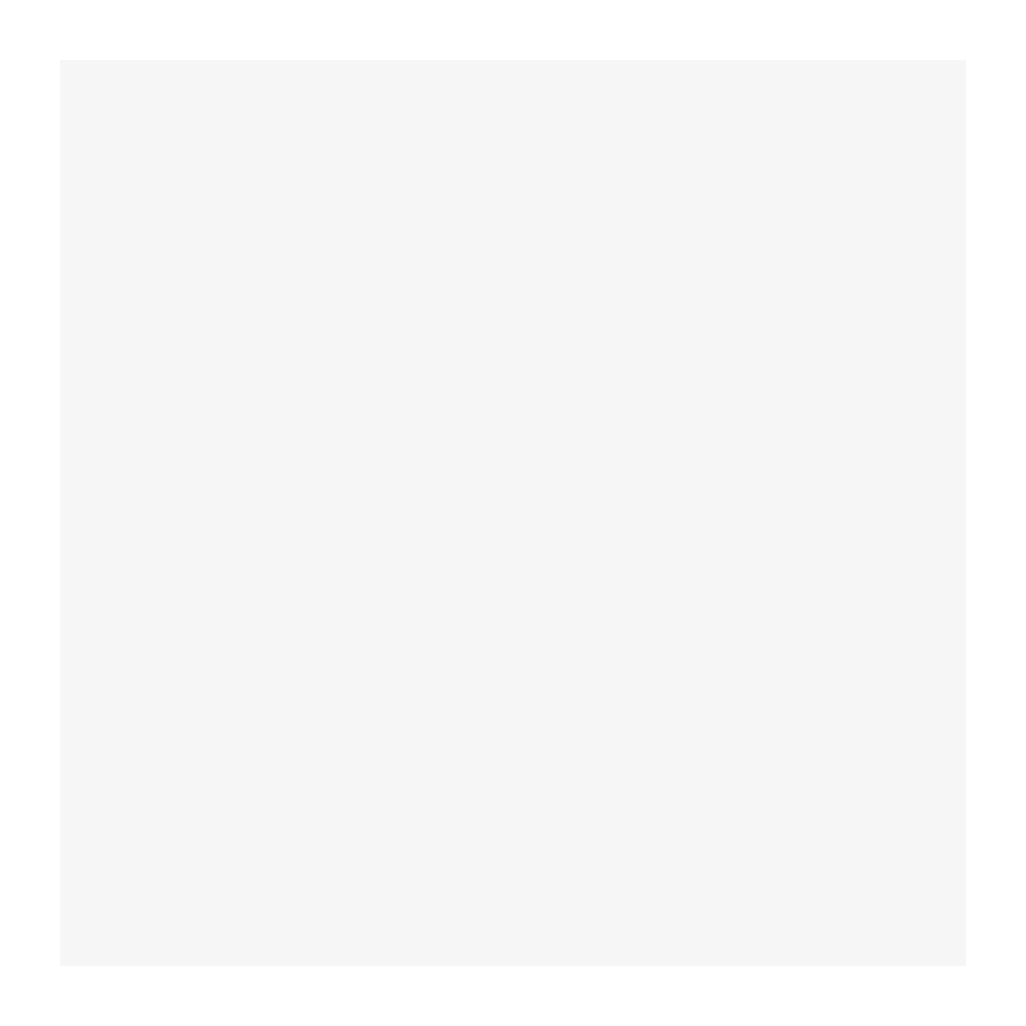

In [102]:
fig = plt.figure(figsize=[2.5,2])
plt.axis('off')
plt.imshow(np.rot90(uy_2D_horizaver), cmap='RdBu_r', vmax=1, vmin=-1)


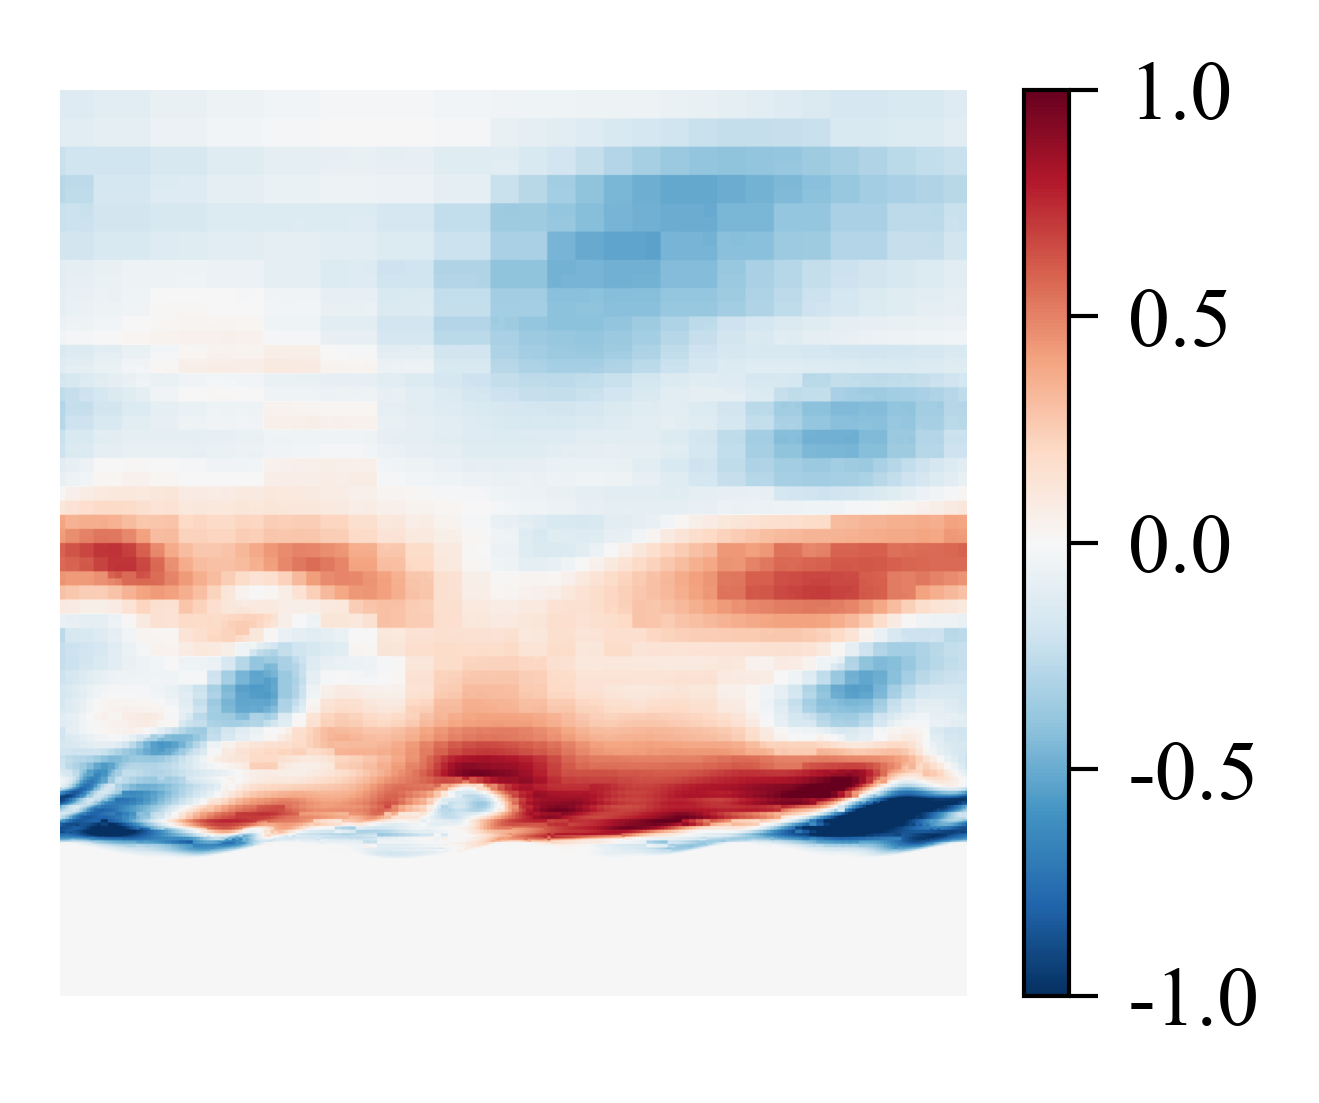

In [103]:
fig = plt.figure(figsize=[2.5,2])
plt.axis('off')
plt.imshow(np.rot90(ux_3D_turb[128]), cmap='RdBu_r', vmax=1, vmin=-1)
plt.colorbar()

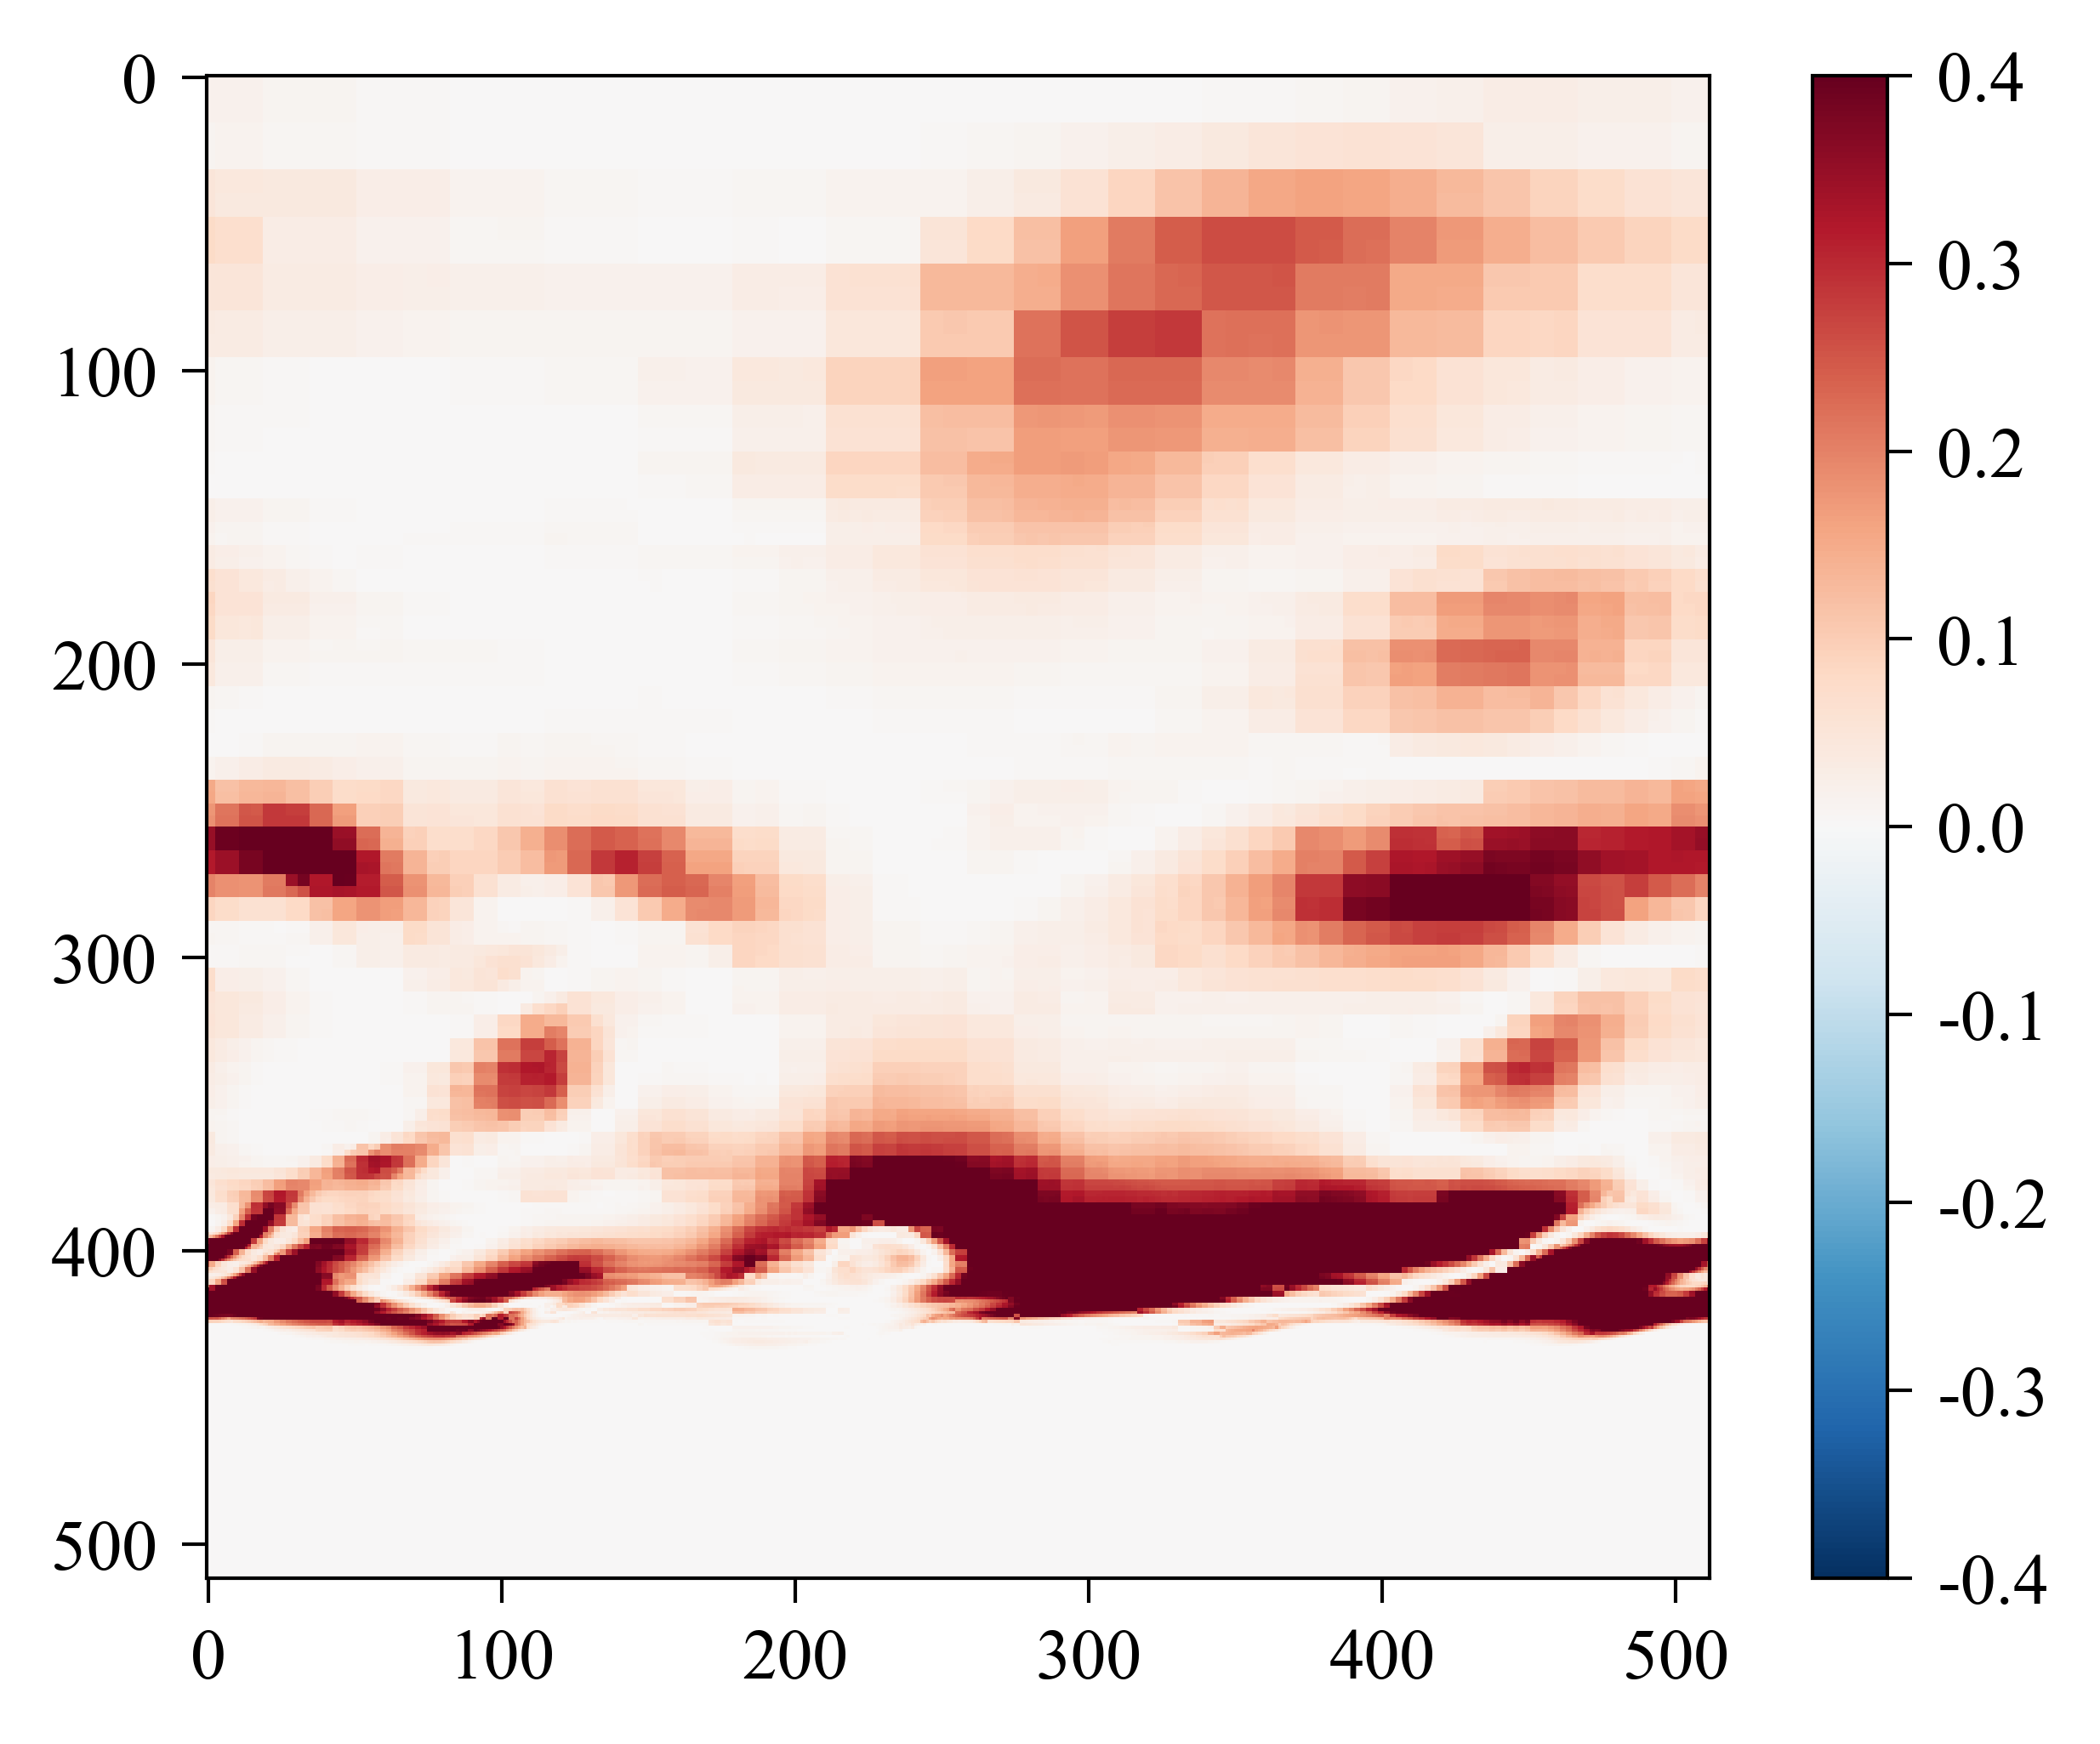

In [104]:
plt.imshow(np.rot90(ux_3D_turb[128]*ux_3D_turb[128]),cmap='RdBu_r', vmax=0.4, vmin=-0.4)
plt.colorbar()

Text(0, 0.5, '$z$')

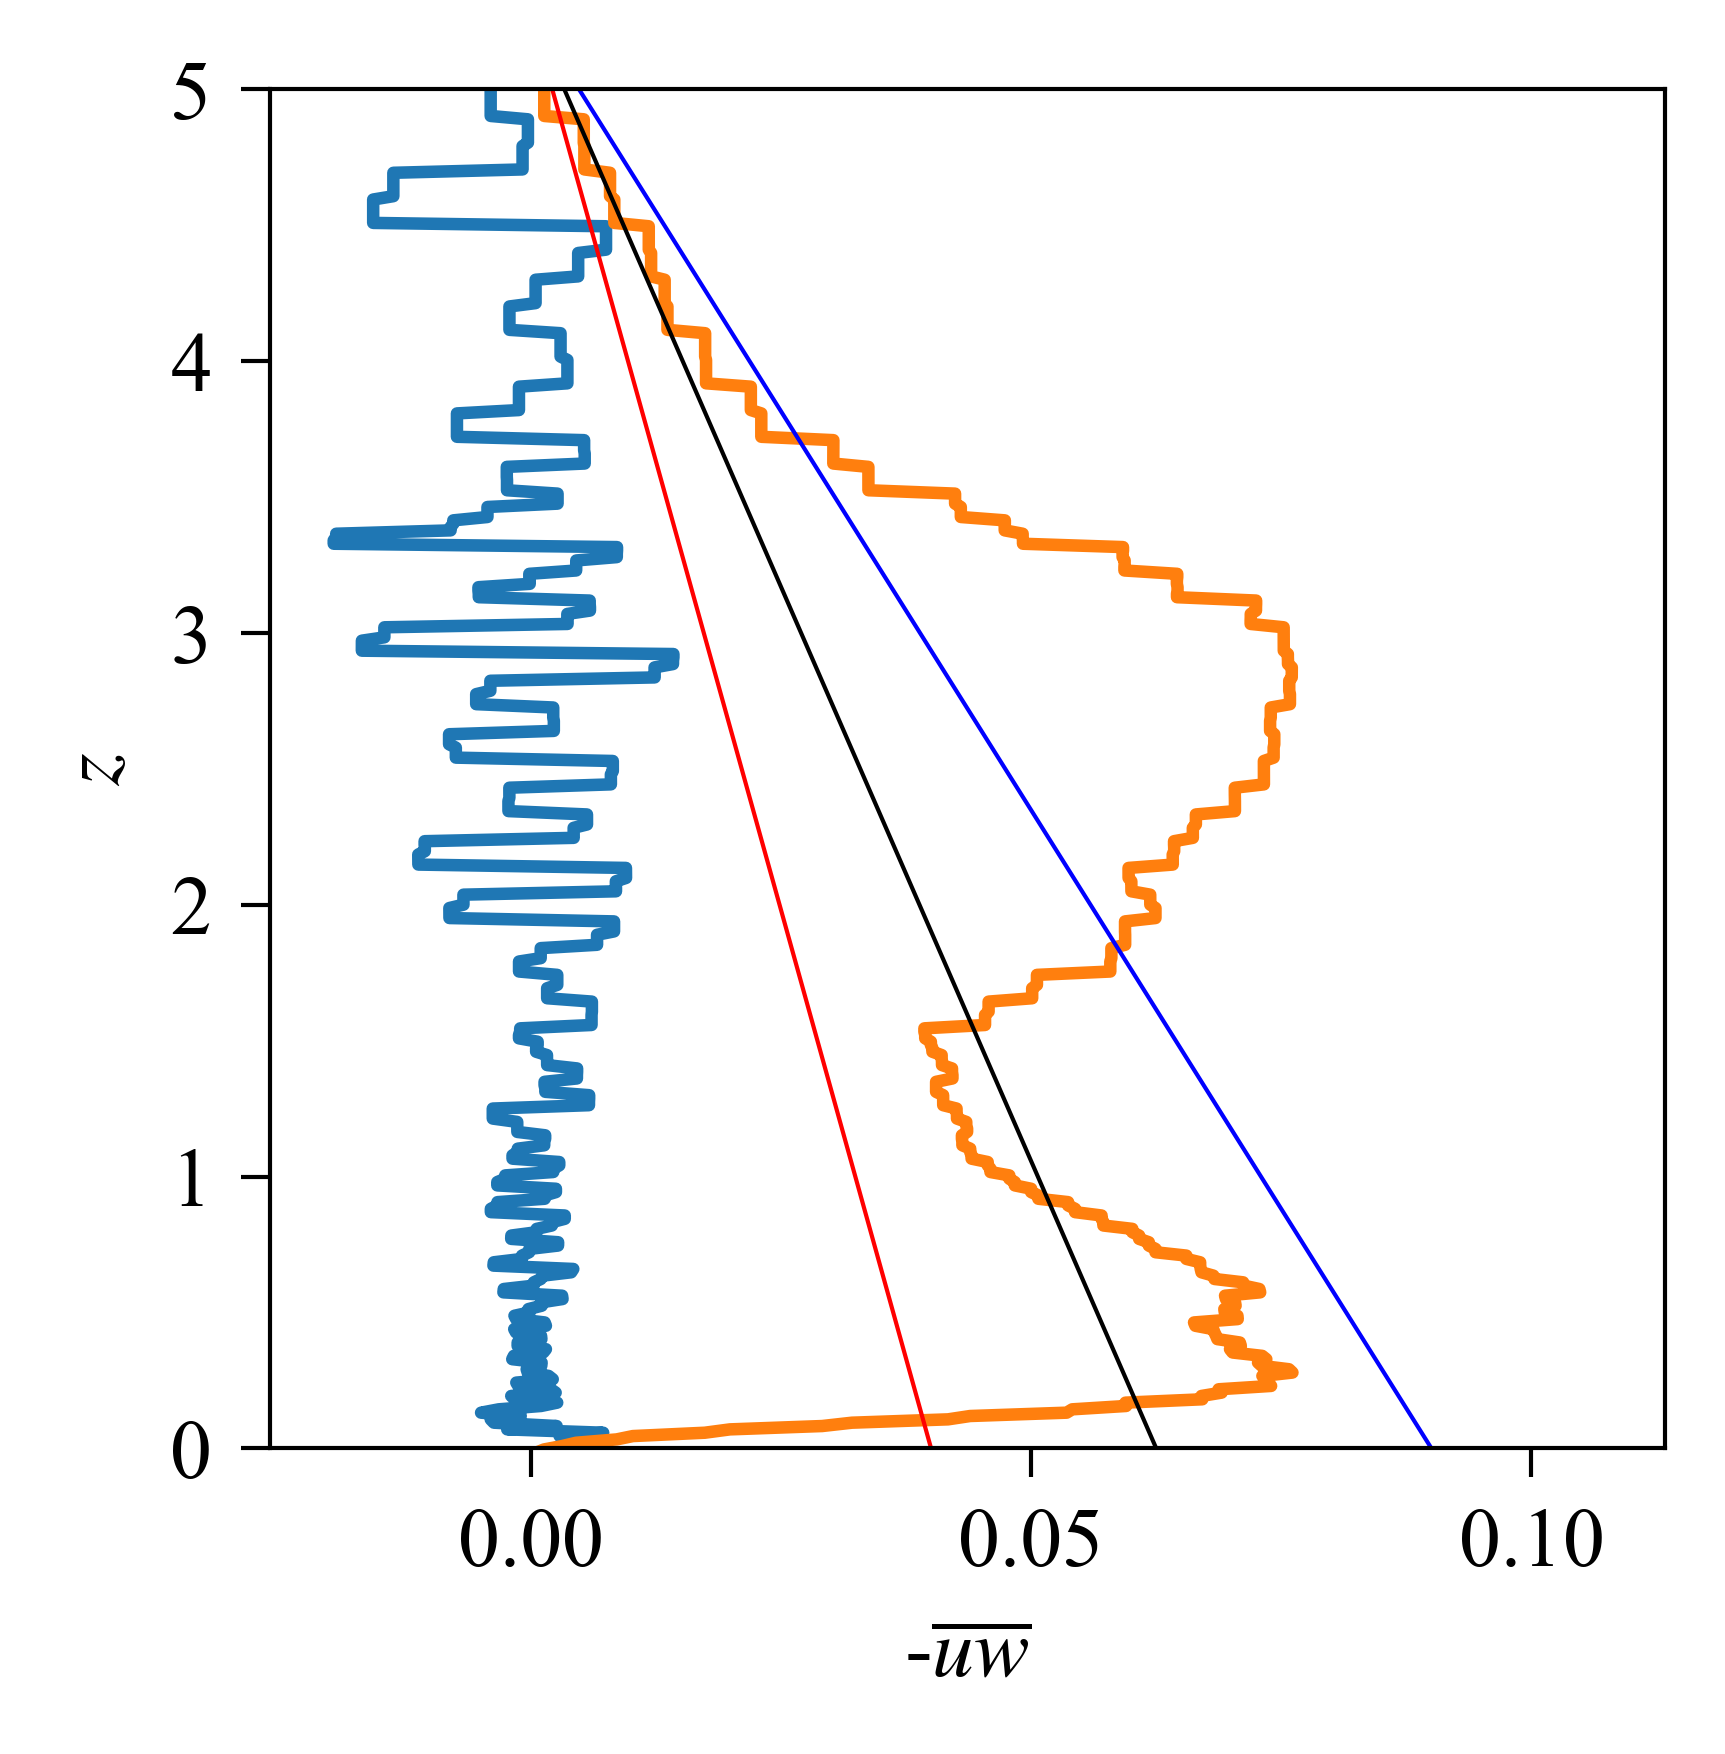

In [108]:
fig = plt.figure(figsize=[3,3])
z = np.linspace(-1,2*np.pi-1,512)
plt.plot(np.average(-ux_2D_phaseaver*uy_2D_phaseaver,axis=0),z)
plt.plot(np.average(-ux_3D_turb*uy_3D_turb,axis=(0,1)),z)
plt.ylim([0,5])
slope = -0.25**2/(2*np.pi-1)
plt.plot(slope*z+0.25**2,z,c='k',lw=0.5)
slope = -0.2**2/(2*np.pi-1)
plt.plot(slope*z+0.2**2,z,c='r',lw=0.5)
slope = -0.3**2/(2*np.pi-1)
plt.plot(slope*z+0.3**2,z,c='b',lw=0.5)
plt.xlabel(r'-$\overline{uw}$')
plt.ylabel(r'$z$')

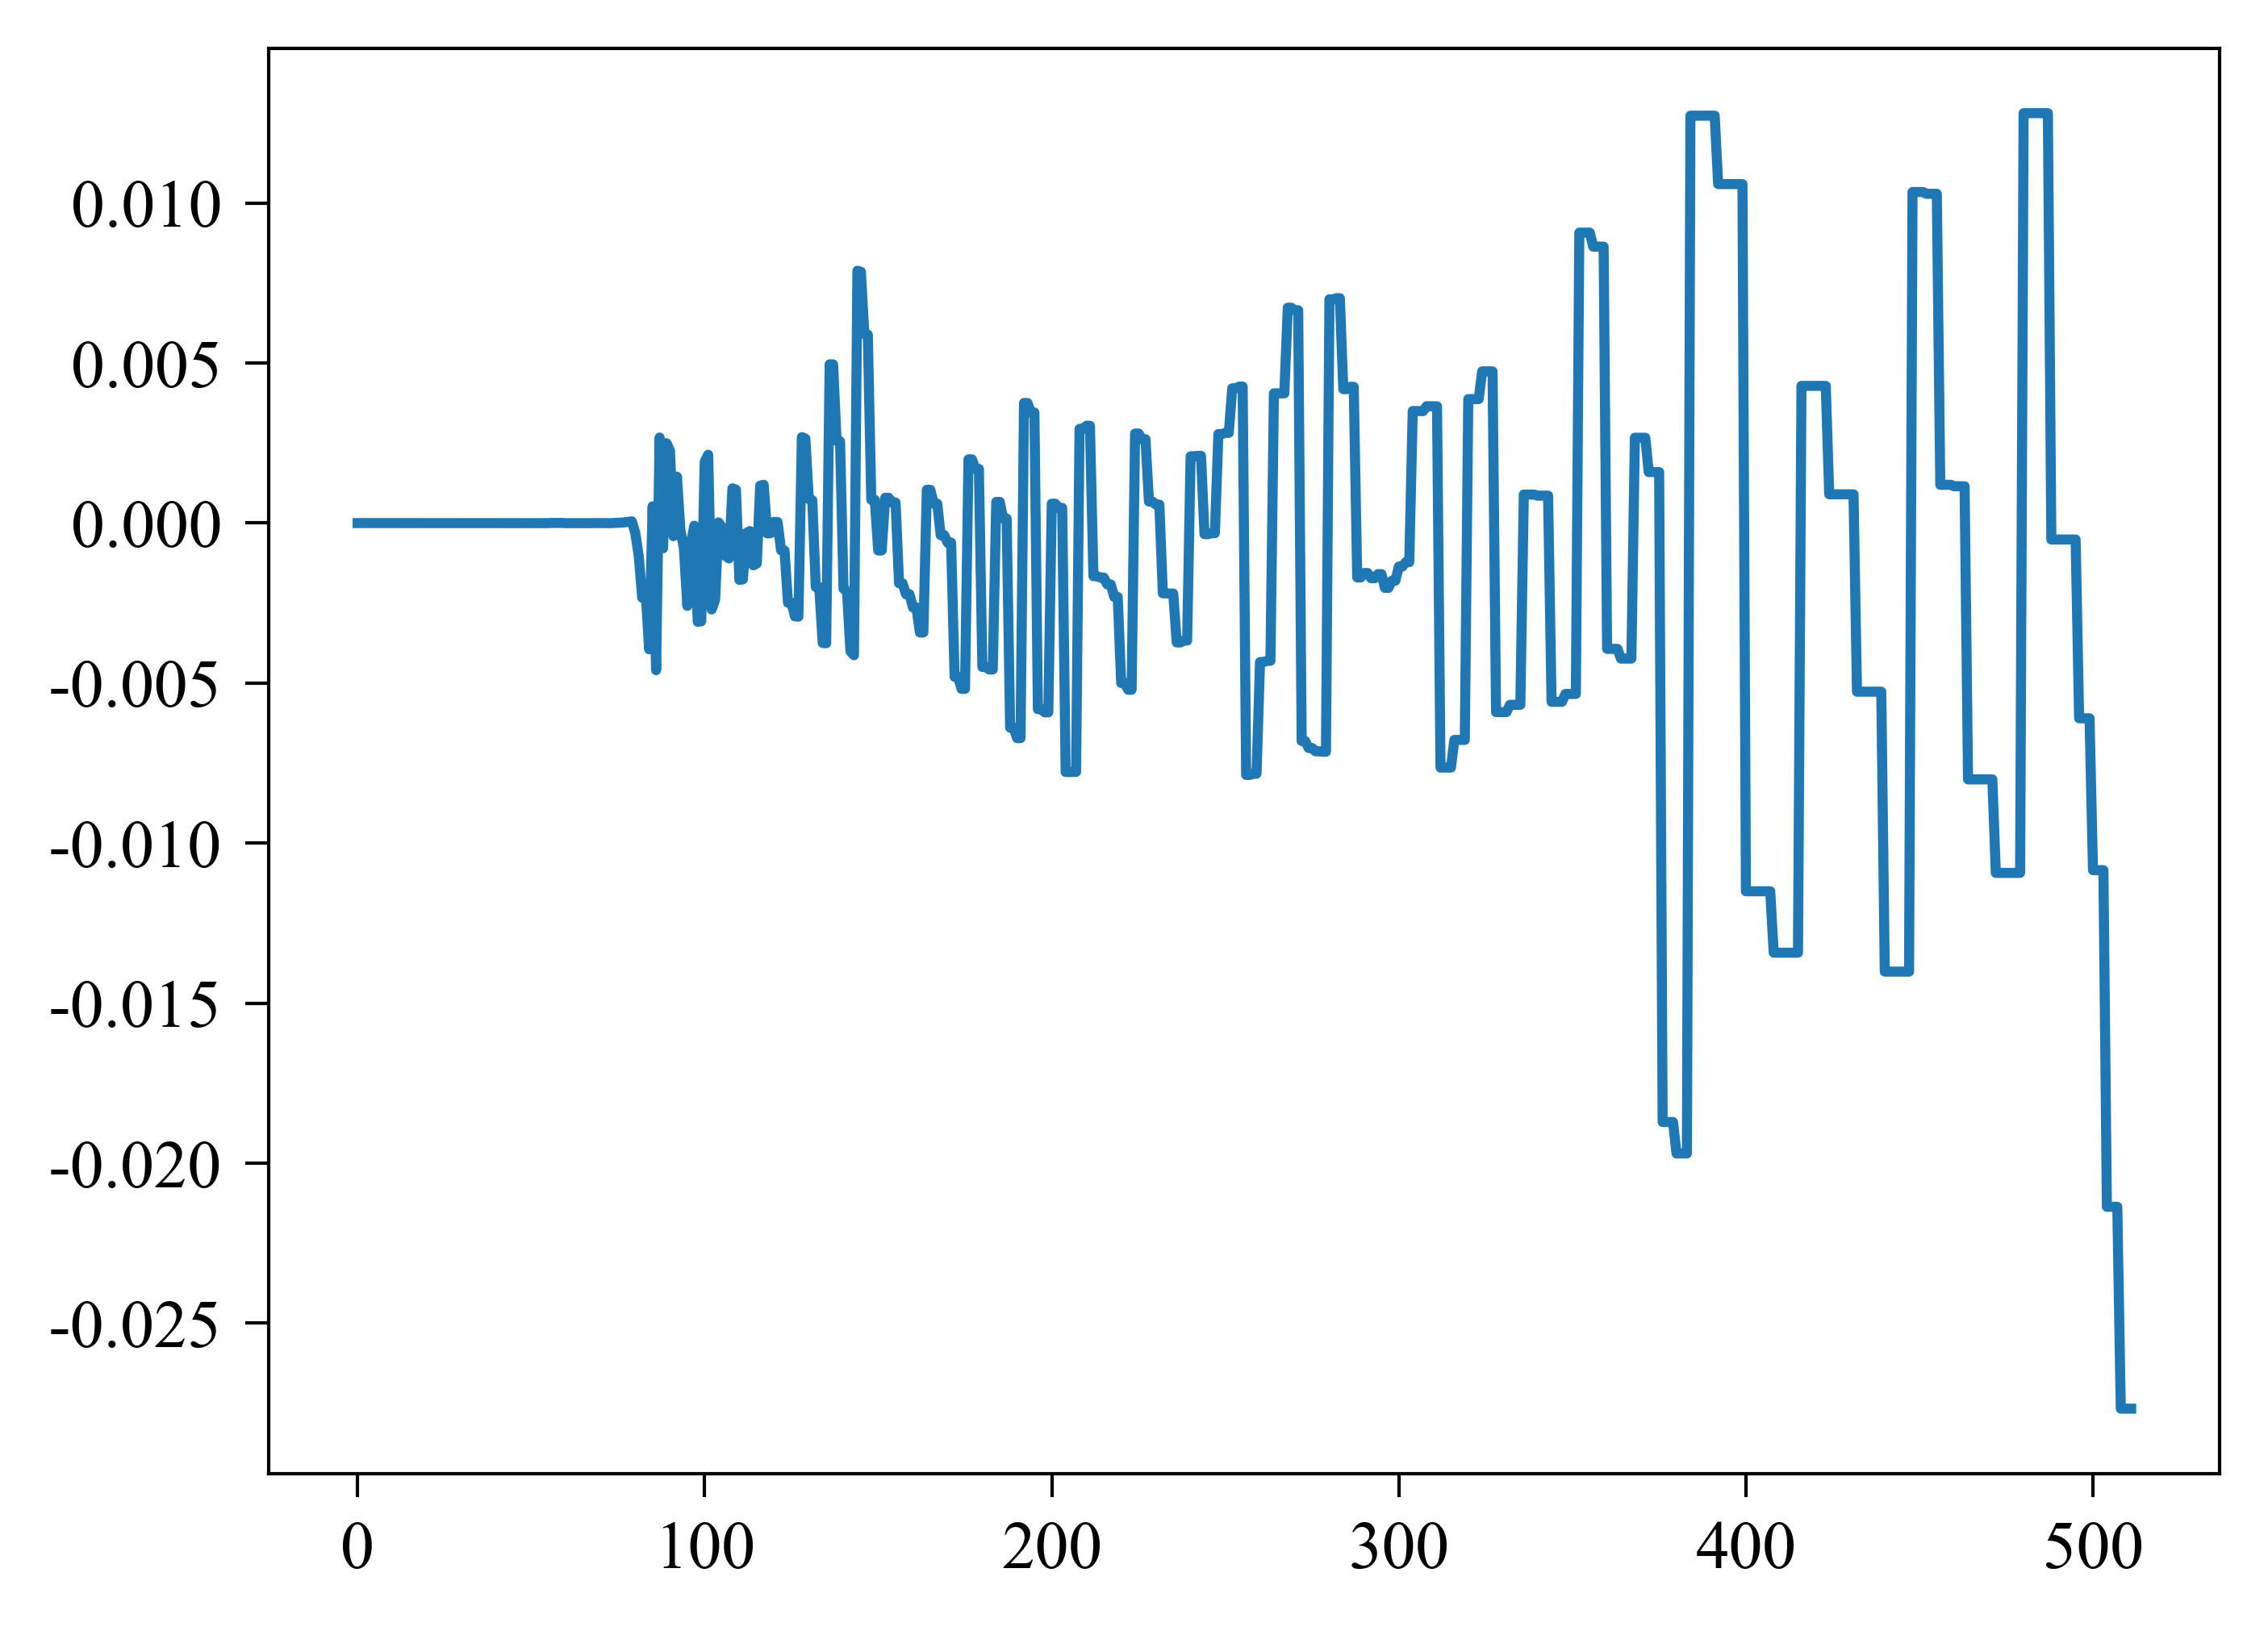

In [73]:
plt.plot(np.average(ux_3D_turb*uy_3D_turb,axis=(0,1))

In [ ]:

ux_3D = {'name':'ux', 'value':[]} # axis0 in z, axis1 in x, axis2 in y  (in the code)
uy_3D = {'name':'uy', 'value':[]}
f_3D = {'name':'f', 'value':[]}
tsimu = t + case.tstart
phasei = np.where(np.isclose(np.array(case.phase['t']), t))[0][0]
idx = case.phase['idx'][phasei]

# Read in the fields either from pickle or from slice data
for field in (ux_3D,uy_3D,f_3D):         
    """NOTICE: to accomodate different pickle versions"""
    picklename = case.path + 'field/' + 'pickle_tiger/' + field['name']+'_t%g' % tsimu +'.pkl'
#             picklename = working_dir + 'field/' + 'pickle_desktop/' + field['name']+'_t%g' % t +'.pkl'
    exists = os.path.exists(picklename)
    # If the pickle is there read in the pickles
    if exists:
        field['value'] = load_object(picklename)
        print('pickle restored!')
    # If no pickle read in from the slice files and pickle dump
    if not exists:
        for sn in range (0, NSLICE-1):
            filename = case.path + 'field/'+field['name']+'_t%g_slice%g' % (tsimu,sn)
            snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
            snapshot.reshape([NGRID,NGRID+1])
            field['value'].append(snapshot[:,0:NGRID].astype(np.float))
        field['value'] = np.array(field['value'])
        save_object(field['value'], picklename)           
    field['value'] = np.roll(field['value'], -idx, axis=1)

re_stress_3D = (ux_3D['value']-ux_3D_phaseaver)*(uy_3D['value']-uy_3D_phaseaver)*(1-f_3D['value'])
re_stress_3D = np.roll(re_stress_3D, -idx, axis=1)   
case.uxuy_2D.append(np.average(re_stress_3D, axis=0))    